# How run_solve_ivp Works

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [ ]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

In general, you don't need to know the details of how all imported functions work in order to use them.  However, having a general idea of what they do can make it easier to use these tools effectively.

One reason is pure curiosity. If you use these methods, and especially
if you come to rely on them, you might find it unsatisfying to treat
them as "black boxes." At the risk of mixing metaphors, I hope you
enjoyed opening the hood.

The other reason is that these methods are not infallible; sometimes
things go wrong. If you know how they work, at least in a general sense,
you might find it easier to debug them.

## How run_solve_ivp Works

`run_solve_ivp` is a function in the ModSimPy library that checks for common errors in the parameters and then calls `solve_ip`, which is the function in the SciPy library that does the actual work.

The general idea of an initial value problem (IVP) solver is that starts at a certain place (i.e. the initial value) and determines later time steps by using the slope.  Say your initial value on a velocity vs. time plot is 10 m/s.  You use a differential equation to find the slope of the velocity at t = 0 (i.e. the acceleration) is 1 m/s/s.  So you might estimate the value at t = 1 to be 11, since the velocity is changing at 1 m/s per second.  Then you calculate the slope at t = 1 s (this is what the `slope_func` does), and find it is 1.2 m/s/s.  So you estimate that the velocity at t = 2 s is 12.2 m/s.   And so on.

You can see that there are some errors in the process, right?  What is the slope at t = 0.5 s, for instance?  Is it really still the same as it was at t = 0 s?

So the rudimentary method described here can be much improved upon, and there are a host of methods, or *algorithms*, that can determine an answer with far less error.  By default, `solve_ivp` uses the Dormand-Prince method, which is a kind of Runge-Kutta method (For details, see
<https://en.wikipedia.org/wiki/Dormand-Prince_method>).

The key idea behind all Runge-Kutta methods is to evaluate the slope function several times at each time step and use a weighted average of the computed slopes to estimate the value at the next time step.
Different methods evaluate the slope function in different places and compute the average with different weights.

So let's see if we can figure out how `solve_ivp` works.
As an example, we'll solve the following differential equation:

$$\frac{dy}{dt}(t) = y \sin t$$

Here's the slope function we'll use:

In [ ]:
import numpy as np

def slope_func(t, state, system):
    y, = state
    dydt = y * np.sin(t)
    return dydt

I'll create a state object with the initial state and a system object with the end time.

In [ ]:
init = pd.Series(dict(y=1))
system = dict(init=init, t_end=3)

Now we can call `run_solve_ivp`.

In [ ]:
results, details = run_solve_ivp(system, slope_func)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 50
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000021D77FC12E0>
   status: 0
  success: True
        t: array([0.0000000e+00, 1.0000000e-04, 1.1000000e-03, 1.1100000e-02,
       1.1110000e-01, 1.1111000e+00, 2.3432724e+00, 3.0000000e+00])
 t_events: None
        y: array([[1.        , 1.        , 1.00000061, 1.00006161, 1.0061843 ,
        1.74444847, 5.46456814, 7.31827074]])
 y_events: None

One of the variables in `details` is `nfev`, which stands for "number of function evaluations", that is, the number of times `solve_ivp` called the slope function.
This example took 50 evaluations.
Keep that in mind.

Here are the first few time steps in `results`: 

In [ ]:
results.head()

,y
0.00,1.000000
0.03,1.000450
0.06,1.001801
0.09,1.004055
0.12,1.007217


And here is the number of time steps.

In [ ]:
len(results)

101

`results` contains 101 points that are equally spaced in time.
Now you might wonder, if `solve_ivp` ran the slope function 50 times, how did we get 101 time steps?

To answer that question, we need to know more how the solver works.
There are actually three steps:

1. For each time step, `solve_ivp` evaluates the slope function seven times, with different values of `t` and `y`.

2. Using the results, it computes the best estimate for the value `y` at the next time step.

3. After computing all of the time steps, it uses interpolation to compute equally spaced points that connect the estimates from the previous step.

So we can see what's happening, I will run `run_solve_ivp` with the keyword argument `dense_output=False`, which skips the interpolation step and returns time steps that are not equally spaced (that is, not "dense").

While we're at it, I'll modify the slope function so that every time it runs, it adds the values of `t`, `y`, and `dydt` to a list called `evals`.

In [ ]:
def slope_func(t, state, system):
    y, = state
    dydt = y * np.sin(t)
    evals.append((t, y, dydt))
    return dydt

Now, before we call `run_solve_ivp` again, I'll initialize `evals` with an empty list.

In [ ]:
evals = []
results2, details = run_solve_ivp(system, slope_func, dense_output=False)

Here are the results:

In [ ]:
results2

,y
0.000000,1.000000
0.000100,1.000000
0.001100,1.000001
0.011100,1.000062
0.111100,1.006184
1.111100,1.744448
2.343272,5.464568
3.000000,7.318271


It turns out there are only eight time steps, and the first five of them only cover 0.11 seconds.

The time steps are not equal because the Dormand-Prince method is *adaptive*.
At each time step, it actually computes two estimates of the next
value. By comparing them, it can estimate the magnitude of the error,
which it uses to adjust the time step. If the error is too big, it uses
a smaller time step; if the error is small enough, it uses a bigger time
step. By adjusting the time step in this way, it minimizes the number
of times it calls the slope function to achieve a given level of
accuracy.

Because we saved the values of `y` and `t`, we can plot the locations where the slope function was evaluated.
I'll need to use a couple of features we have not seen before, if you don't mind.

First we'll unpack the values from `evals` using `np.transpose`.
Then we can use trigonometry to convert the slope, `dydt`, to components called `u` and `v`.

In [ ]:
t, y, slope = np.transpose(evals)
theta = np.arctan(slope)
u = np.cos(theta)
v = np.sin(theta)

Using these values, we can generate a *quiver plot* that shows an arrow for each time the slope function ran.
The location of the each arrow represents the values of `t` and `y`; the orientation of the arrow shows the slope that was computed.

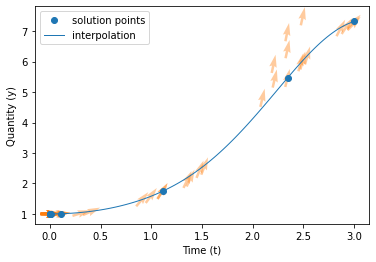

In [ ]:
import matplotlib.pyplot as plt

plt.quiver(t, y, u, v, pivot='middle', 
           color='C1', alpha=0.4, label='evaluation points')
results2['y'].plot(style='o', color='C0', 
                   label='solution points',
                  legend=True)
results['y'].plot(lw=1, label='interpolation',
                  xlabel='Time (t)',
                  ylabel='Quantity (y)',
                 legend=True);

In this figure, the arrows show where the slope function was executed;
the dots show the best estimate of `y` for each time step; and the line shows the interpolation that connects the estimates.

Notice that many of the arrows do not fall on the line; `solve_ivp` evaluated the slope function at these locations in order to compute the solution, but as it turned out, they are not part of the solution.

This is good to know when you are writing a slope function; you should not assume that the time and state you get as input variables are correct.